# Training Without Duplicates on Short Clues
Now that we have removed duplicates and short clues let's take a fresh look at where we are.

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline

def plot_files(files):
    offsets = [1] * len(files)

    labels_and_results = []
    color_map = list(mcolors.TABLEAU_COLORS.keys())

    for (label, file) in files:
        with open(file, 'r') as f:
            result = json.load(f)
            labels_and_results.append((label, result))


    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

    for i in range(len(files)):
        label = labels_and_results[i][0]
        result = labels_and_results[i][1]

        num_data_points = len(result['elapsed_times'])
        epoch_start = offsets[i]
        epoch_range = list(range(epoch_start, epoch_start + num_data_points))

        axs[0].plot(epoch_range, result['dev_losses'], color_map[i], linestyle='--', label=label + '_dev')
        axs[0].plot(epoch_range, result['train_losses'], color_map[i], label=label + '_train')

        axs[1].plot(epoch_range, result['dev_accu_pcts'], color_map[i], linestyle='--')
        axs[1].plot(epoch_range, result['train_accu_pcts'], color_map[i])

    axs[0].set_title('Epoch vs Loss')
    axs[1].set_title('Epoch vs Accuracy')
    axs[0].xaxis.set_major_locator(mticker.MultipleLocator(5))
    axs[0].set_ylim(ymin = 0.0, ymax=15.0)
    axs[1].xaxis.set_major_locator(mticker.MultipleLocator(5))
    axs[1].set_ylim(ymin = 0.0, ymax=1.0)
    fig.legend(bbox_to_anchor=(1.0, 1), loc="upper left")

Let's take a look at the best model we have so far trained agains the dataset with dupes and without to understand what we're working with here.
```
python trainer/task.py --batch-size 128 --num-epochs 50 --device mps --learning-rate 0.0005 --weight-decay 0.1 --embedding-dimensions 100 --hidden-layer-size 300 --output-folder 100d300n-exp1 --model-name none
```

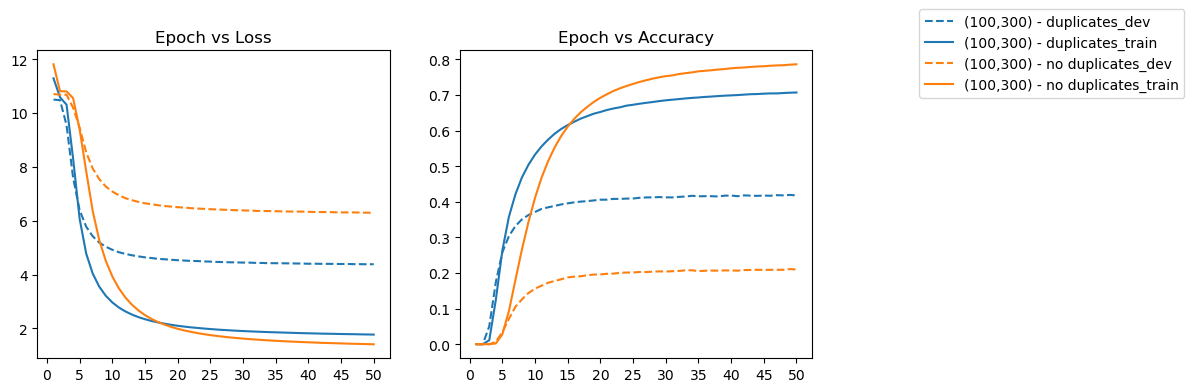

In [47]:
files = [
    ('(100,300) - duplicates', 'training_results/20230321-212618-training/training-results.json'), # duplicates
    ('(100,300) - no duplicates', 'training_results/100d300n-exp1/training-results.json'), # no dupes
]
plot_files(files)

Let's try to bump up the batch size for some faster training:
```
python trainer/task.py --batch-size 512 --num-epochs 50 --device mps --learning-rate 0.001 --weight-decay 0.1 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 1 --output-folder depth-search-100-300-1 --model-name none
python trainer/task.py --batch-size 128 --num-epochs 50 --device cpu --learning-rate 0.0005 --weight-decay 0.1 --embedding-dimensions 100 --hidden-layer-size 300 --output-folder reproduce-attempt --model-name none
```

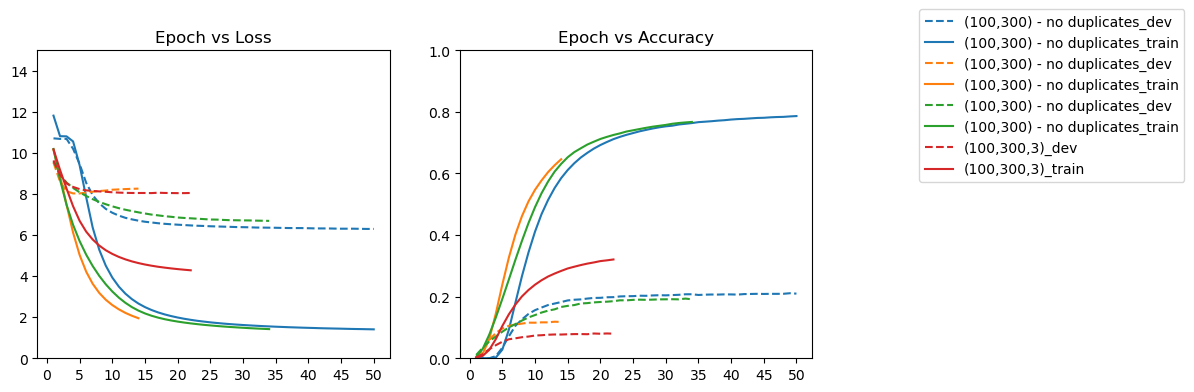

In [50]:
files = [
    ('(100,300) - no duplicates', 'training_results/100d300n-exp1/training-results.json'), # trained on dataset with larger clues
    ('(100,300) - no duplicates', 'training_results/depth-search-100-300-1/training-results.json'), # trained on correct dataset, halted due to plateau
    ('(100,300) - no duplicates', 'training_results/reproduce-attempt/training-results.json'), # in progress on CPU right now
    ('(100,300,3)', 'training_results/100-300-3/training-results.json'), # in progress on CPU right now
]
plot_files(files)

Given the difference I have to assume that our model is not powerful enough to actually learn about the test set and is just memorizing mappings. Let's try adding some depth:

```
python trainer/task.py --batch-size 512 --num-epochs 50 --device mps --learning-rate 0.001 --weight-decay 0.1 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 3 --output-folder depth-search-100-300-3 --model-name none
```

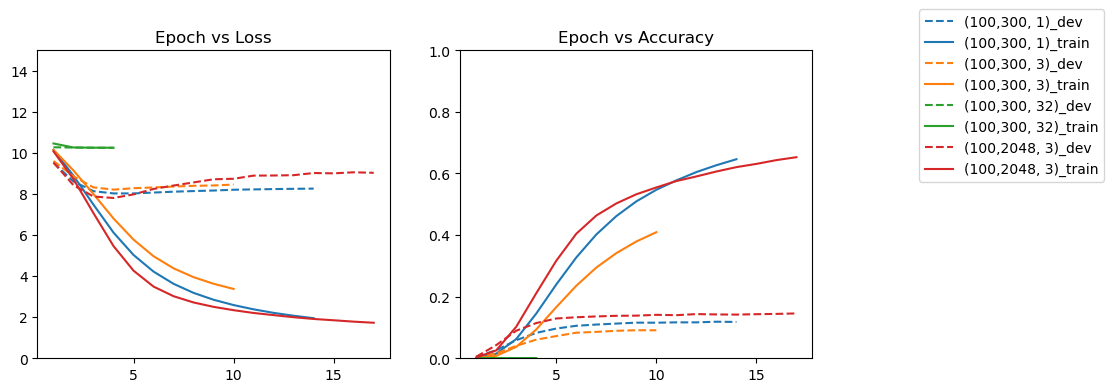

In [49]:
files = [
    ('(100,300, 1)', 'training_results/depth-search-100-300-1/training-results.json'),
    #vs
    ('(100,300, 3)', 'training_results/depth-search-100-300-3/training-results.json'),
    ('(100,300, 32)', 'training_results/depth-search-100-300-32/training-results.json'),
    ('(100,2048, 3)', 'training_results/depth-search-100-2048-3/training-results.json'),
]
plot_files(files)

**Important Note: my first pass at this was storing layers as a python list instead of a ModuleList which made them not actually trainable! 🤦‍♂️**

Let's reasses things:
* Work with smaller networks
* Get batch size back up for faster training

```
python trainer/task.py --batch-size 512 --num-epochs 20 --device cpu --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 8 --hidden-layer-size 128 --hidden-depth 4 --output-folder depth-search-8-128-4 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device cpu --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 8 --hidden-layer-size 128 --hidden-depth 8 --output-folder depth-search-8-128-8 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device cpu --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 8 --hidden-layer-size 128 --hidden-depth 16 --output-folder depth-search-8-128-16 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device cpu --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 8 --hidden-layer-size 128 --hidden-depth 32 --output-folder depth-search-8-128-32 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device cpu --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 8 --hidden-layer-size 128 --hidden-depth 64 --output-folder depth-search-8-128-64 --model-name none
```
```
python trainer/task.py --batch-size 512 --num-epochs 20 --device mps --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 16 --hidden-layer-size 64 --hidden-depth 4 --output-folder depth-search-16-64-4 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device mps --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 16 --hidden-layer-size 64 --hidden-depth 8 --output-folder depth-search-16-64-8 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device mps --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 16 --hidden-layer-size 64 --hidden-depth 16 --output-folder depth-search-16-64-16 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device mps --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 16 --hidden-layer-size 64 --hidden-depth 32 --output-folder depth-search-16-64-32 --model-name none
python trainer/task.py --batch-size 512 --num-epochs 20 --device mps --learning-rate 0.01 --weight-decay 0.0 --embedding-dimensions 16 --hidden-layer-size 64 --hidden-depth 64 --output-folder depth-search-16-64-64 --model-name none
```

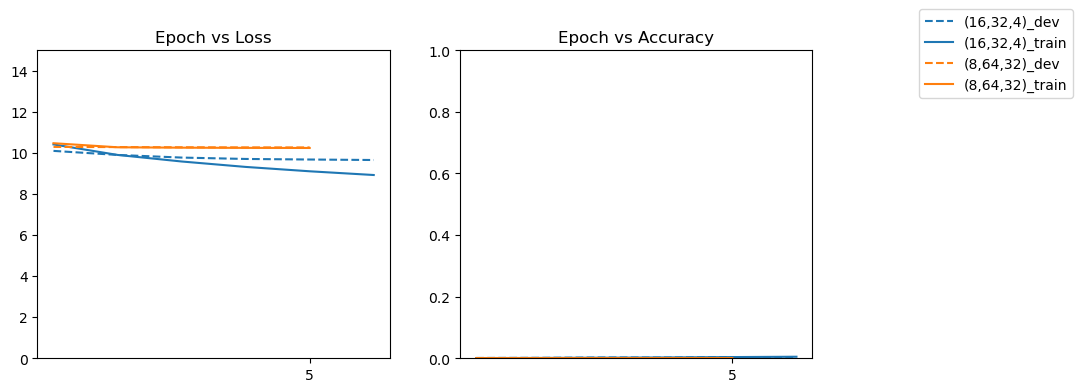

In [46]:
files = [
    ('(16,32,4)', 'training_results/depth-search-16-32-4/training-results.json'),
    ('(8,64,32)', 'training_results/depth-search-8-64-32/training-results.json'),
]
plot_files(files)

If we compare the previous two graps it seems like removing the weight initialization did help. We also seem to have found the upper and lower bounds for our LR:
```
0.0001 < LR < 0.01
```

Let's see the impact of using different numbers of layers:
```
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 1 --output-folder 100-300-1 --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 2 --output-folder 100-300-2 --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 3 --output-folder 100-300-3 --model-name none
```

```
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.003 --weight-decay 0.01 --embedding-dimensions 100 --hidden-layer-size 300 --hidden-depth 10 --output-folder 100-300-10 --model-name none
```

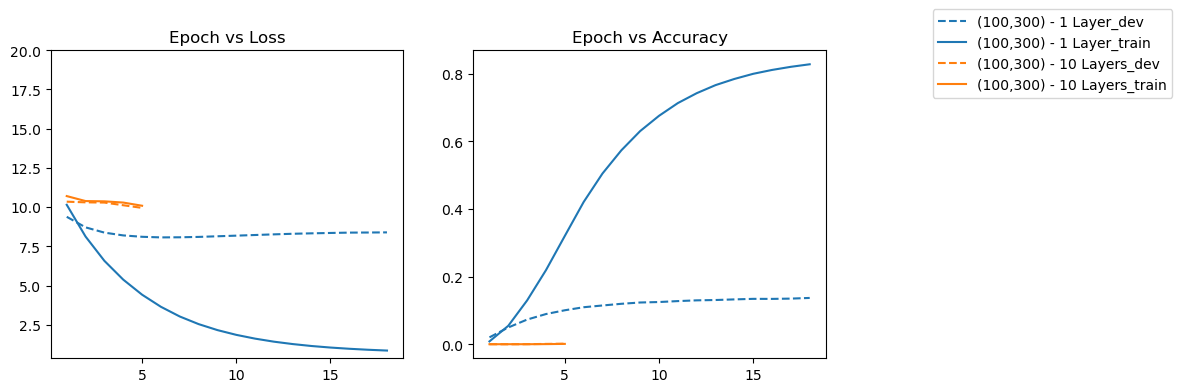

In [81]:
files = [
    ('(100,300) - 1 Layer', 'training_results/100-300-1/training-results.json'), # no dupes
    #('(100,300) - 2 Layers', 'training_results/100-300-2/training-results.json'), # no dupes
    #('(100,300) - 3 Layers', 'training_results/100-300-3/training-results.json'), # no dupes
    ('(100,300) - 10 Layers', 'training_results/100-300-10/training-results.json'), # no dupes
]
plot_files(files)